# 第10章 数据聚合与分组运算

pandas提供了一个灵活高效的gruopby功能，它使你能以一种自然的方式对数据集进行切片、切块、摘要等操作。
关系型数据库和SQL（Structured Query Language，结构化查询语言）能够如此流行的原因之一就是其能够方便地对数据进行连接、过滤、转换和聚合。但是，像SQL这样的查询语言所能执行的分组运算的种类很有限。

使用一个或多个键（形式可以是函数、数组或DataFrame列名）分割pandas对象。
计算分组的概述统计，比如数量、平均值或标准差，或是用户定义的函数。
应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。
计算透视表或交叉表。
执行分位数分析以及其它统计分组分析。

笔记：对时间序列数据的聚合（groupby的特殊用法之一）也称作重采样（resampling），本书将在第11章中单独对其进行讲解。

## 10.1 GroupBy机制

Hadley Wickham（许多热门R语言包的作者）创造了一个用于表示分组运算的术语"split-apply-combine"（拆分－应用－合并）。第一个阶段，pandas对象（无论是Series、DataFrame还是其他的）中的数据会根据你所提供的一个或多个键被拆分（split）为多组。拆分操作是在对象的特定轴上执行的。例如，DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。然后，将一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。结果对象的形式一般取决于数据上所执行的操作。图10-1大致说明了一个简单的分组聚合过程。

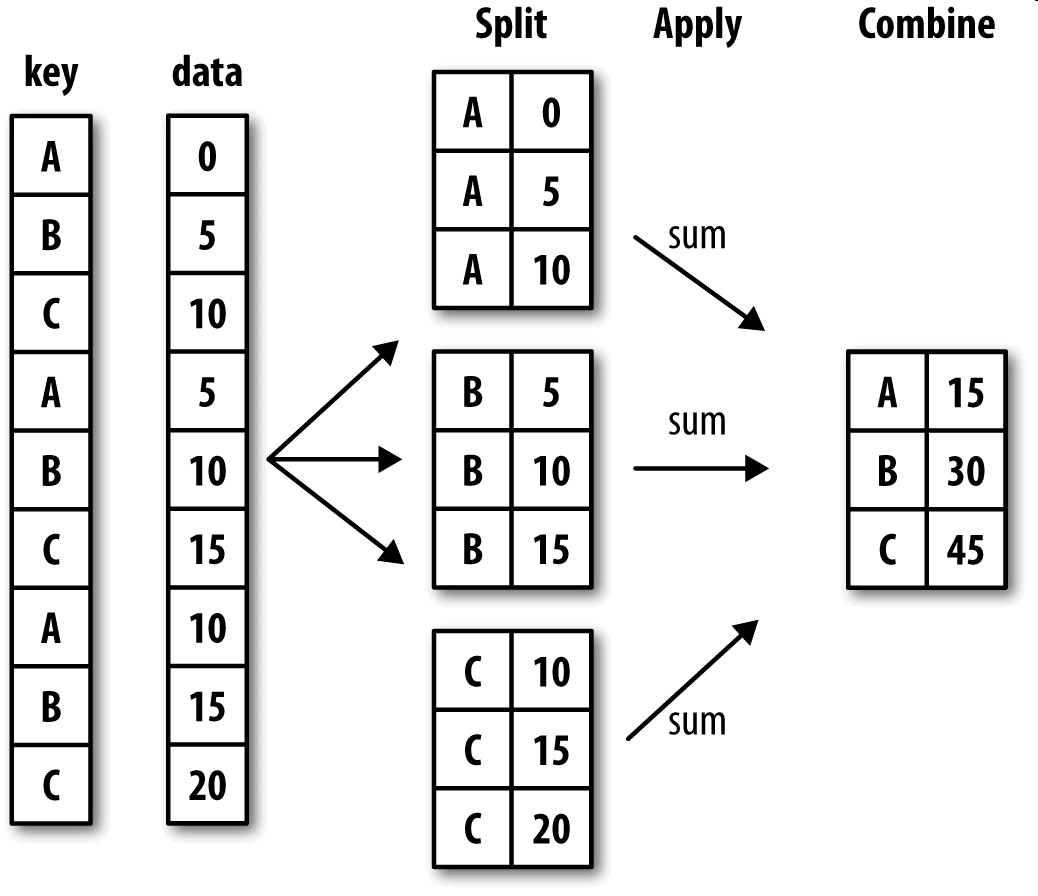

分组键可以有多种形式，且类型不必相同：

列表或数组，其长度与待分组的轴一样。
表示DataFrame某个列名的值。
字典或Series，给出待分组轴上的值与分组名之间的对应关系。
函数，用于处理轴索引或索引中的各个标签。

注意，后三种都只是快捷方式而已，其最终目的仍然是产生一组用于拆分对象的值。

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [5]:
df

,key1,key2,data1,data2
0,a,one,-0.399270,2.475680
1,a,two,-1.693217,2.113885
2,b,one,0.371885,1.355767
3,b,two,0.024067,1.587902
4,a,one,-0.312756,0.873572


假设你想要按key1进行分组，并计算data1列的平均值。实现该功能的方式有很多，而我们这里要用的是：访问data1，并根据key1调用groupby：

In [6]:
grouped = df['data1'].groupby(df['key1'])

In [7]:
grouped

变量grouped是一个GroupBy对象。它实际上还没有进行任何计算，只是含有一些有关分组键df['key1']的中间数据而已。换句话说，该对象已经有了接下来对各分组执行运算所需的一切信息。例如，我们可以调用GroupBy的mean方法来计算分组平均值：

In [8]:
grouped.mean()

key1
a   -0.801748
b    0.197976
Name: data1, dtype: float64

数据（Series）根据分组键进行了聚合，产生了一个新的Series，其索引为key1列中的唯一值。
如果我们一次传入多个数组的列表，就会得到不同的结果：

In [9]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [10]:
means

key1  key2
a     one    -0.356013
      two    -1.693217
b     one     0.371885
      two     0.024067
Name: data1, dtype: float64

这里，我通过两个键对数据进行了分组，得到的Series具有一个层次化索引（由唯一的键对组成）：

In [11]:
means.unstack()

key2,one,two
key1,,
a,-0.356013,-1.693217
b,0.371885,0.024067


在这个例子中，分组键均为Series。实际上，分组键可以是任何长度适当的数组：

In [12]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [13]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [14]:
df['data1'].groupby([states, years]).mean()

California  2005   -1.693217
            2006    0.371885
Ohio        2005   -0.187602
            2006   -0.312756
Name: data1, dtype: float64

通常，分组信息就位于相同的要处理DataFrame中。这里，你还可以将列名（可以是字符串、数字或其他Python对象）用作分组键：

In [15]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.801748,1.821046
b,0.197976,1.471835


In [16]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.356013  1.674626
     two  -1.693217  2.113885
b    one   0.371885  1.355767
     two   0.024067  1.587902

第一个例子在执行df.groupby('key1').mean()时，结果中没有key2列。这是因为df['key2']不是数值数据（俗称“麻烦列”），所以被从结果中排除了。默认情况下，所有数值列都会被聚合，虽然有时可能会被过滤为一个子集，稍后就会碰到。

无论你准备拿groupby做什么，都有可能会用到GroupBy的size方法，它可以返回一个含有分组大小的Series：

In [17]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

注意，任何分组关键词中的缺失值，都会被从结果中除去。

### 对分组进行迭代

GroupBy对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）。看下面的例子：

In [18]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one -0.399270  2.475680
1    a  two -1.693217  2.113885
4    a  one -0.312756  0.873572
b
  key1 key2     data1     data2
2    b  one  0.371885  1.355767
3    b  two  0.024067  1.587902


对于多重键的情况，元组的第一个元素将会是由键值组成的元组：

In [19]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.399270  2.475680
4    a  one -0.312756  0.873572
('a', 'two')
  key1 key2     data1     data2
1    a  two -1.693217  2.113885
('b', 'one')
  key1 key2     data1     data2
2    b  one  0.371885  1.355767
('b', 'two')
  key1 key2     data1     data2
3    b  two  0.024067  1.587902


当然，你可以对这些数据片段做任何操作。有一个你可能会觉得有用的运算：将这些数据片段做成一个字典：

In [20]:
pieces = dict(list(df.groupby('key1')))

In [21]:
pieces['b']

,key1,key2,data1,data2
2,b,one,0.371885,1.355767
3,b,two,0.024067,1.587902


groupby默认是在axis=0上进行分组的，通过设置也可以在其他任何轴上进行分组。拿上面例子中的df来说，我们可以根据dtype对列进行分组：

In [22]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [23]:
grouped = df.groupby(df.dtypes, axis=1)

In [24]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.399270  2.475680
1 -1.693217  2.113885
2  0.371885  1.355767
3  0.024067  1.587902
4 -0.312756  0.873572
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选取一列或列的子集

对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的。也就是说：

In [25]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

是以下代码的语法糖：

In [26]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

尤其对于大数据集，很可能只需要对部分列进行聚合。例如，在前面那个数据集中，如果只需计算data2列的平均值并以DataFrame形式得到结果，可以这样写：

In [27]:
In [31]: df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.674626
     two   2.113885
b    one   1.355767
     two   1.587902

这种索引操作所返回的对象是一个已分组的DataFrame（如果传入的是列表或数组）或已分组的Series（如果传入的是标量形式的单个列名）：

In [28]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [29]:
s_grouped

In [30]:
s_grouped.mean()

key1  key2
a     one     1.674626
      two     2.113885
b     one     1.355767
      two     1.587902
Name: data2, dtype: float64

### 通过字典或Series进行分组

除数组以外，分组信息还可以其他形式存在。来看另一个示例DataFrame：

In [31]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [32]:
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values

In [33]:
people

,a,b,c,d,e
Joe,0.831363,-0.424732,1.028175,-1.922445,-0.497686
Steve,-0.641488,0.803737,-0.835479,-1.096097,-0.314619
Wes,-2.187505,NaN,NaN,0.063727,-0.170614
Jim,0.083386,-1.479414,-0.151647,-0.875881,1.467133
Travis,-0.832861,1.303542,0.831366,0.234725,-0.346330


### 通过函数进行分组

### 根据索引级别分组

## 10.2 数据聚合

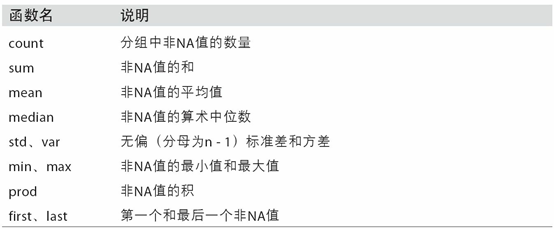

### 面向列的多函数应用

### 以“没有行索引”的形式返回聚合数据

## 10.3 apply：一般性的“拆分－应用－合并”

最通用的GroupBy方法是apply，本节剩余部分将重点讲解它。如图10-2所示，apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

### 禁止分组键

### 分位数和桶分析

### 示例：用特定于分组的值填充缺失值

### 示例：随机采样和排列

### 示例：分组加权平均数和相关系数

### 示例：组级别的线性回归

## 10.4 透视表和交叉表

### 交叉表：crosstab